# Курс «Глубокое обучение в компьютерном зрении»

### Урок 4. Семантическая сегментация

### Домашнее задание к уроку 4

Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO
Библиотеки: [Python, Tensorflow]

In [1]:
import random
import imageio
import os
import skimage.io as io
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from pycocotools.coco import COCO

## Загрузка датасета COCO и COCO API

Для начала готовим кастомный датасет

In [2]:
# Устанавливаем номальную кодировку, чтобы хотя бы по английски все отображалось
!chcp 65001

Active code page: 65001


In [3]:
# Если не устанвлен API для датасета, устанавливаем его
# !pip install pycocotools

In [4]:
# !pip install pycoco

In [5]:
# Переходим в папку где находятся наши датасеты, заранее загруженные и распакованные.
!cd D:\DZ\COCO

In [6]:
COCO_ROOT = 'D:\DZ\COCO'

## Универсальный класс Dataset для сегментации

In [7]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [8]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [9]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=19.31s)
creating index...
index created!
loading annotations into memory...
Done (t=0.71s)
creating index...
index created!


In [10]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((128, 128, 3))
    
    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

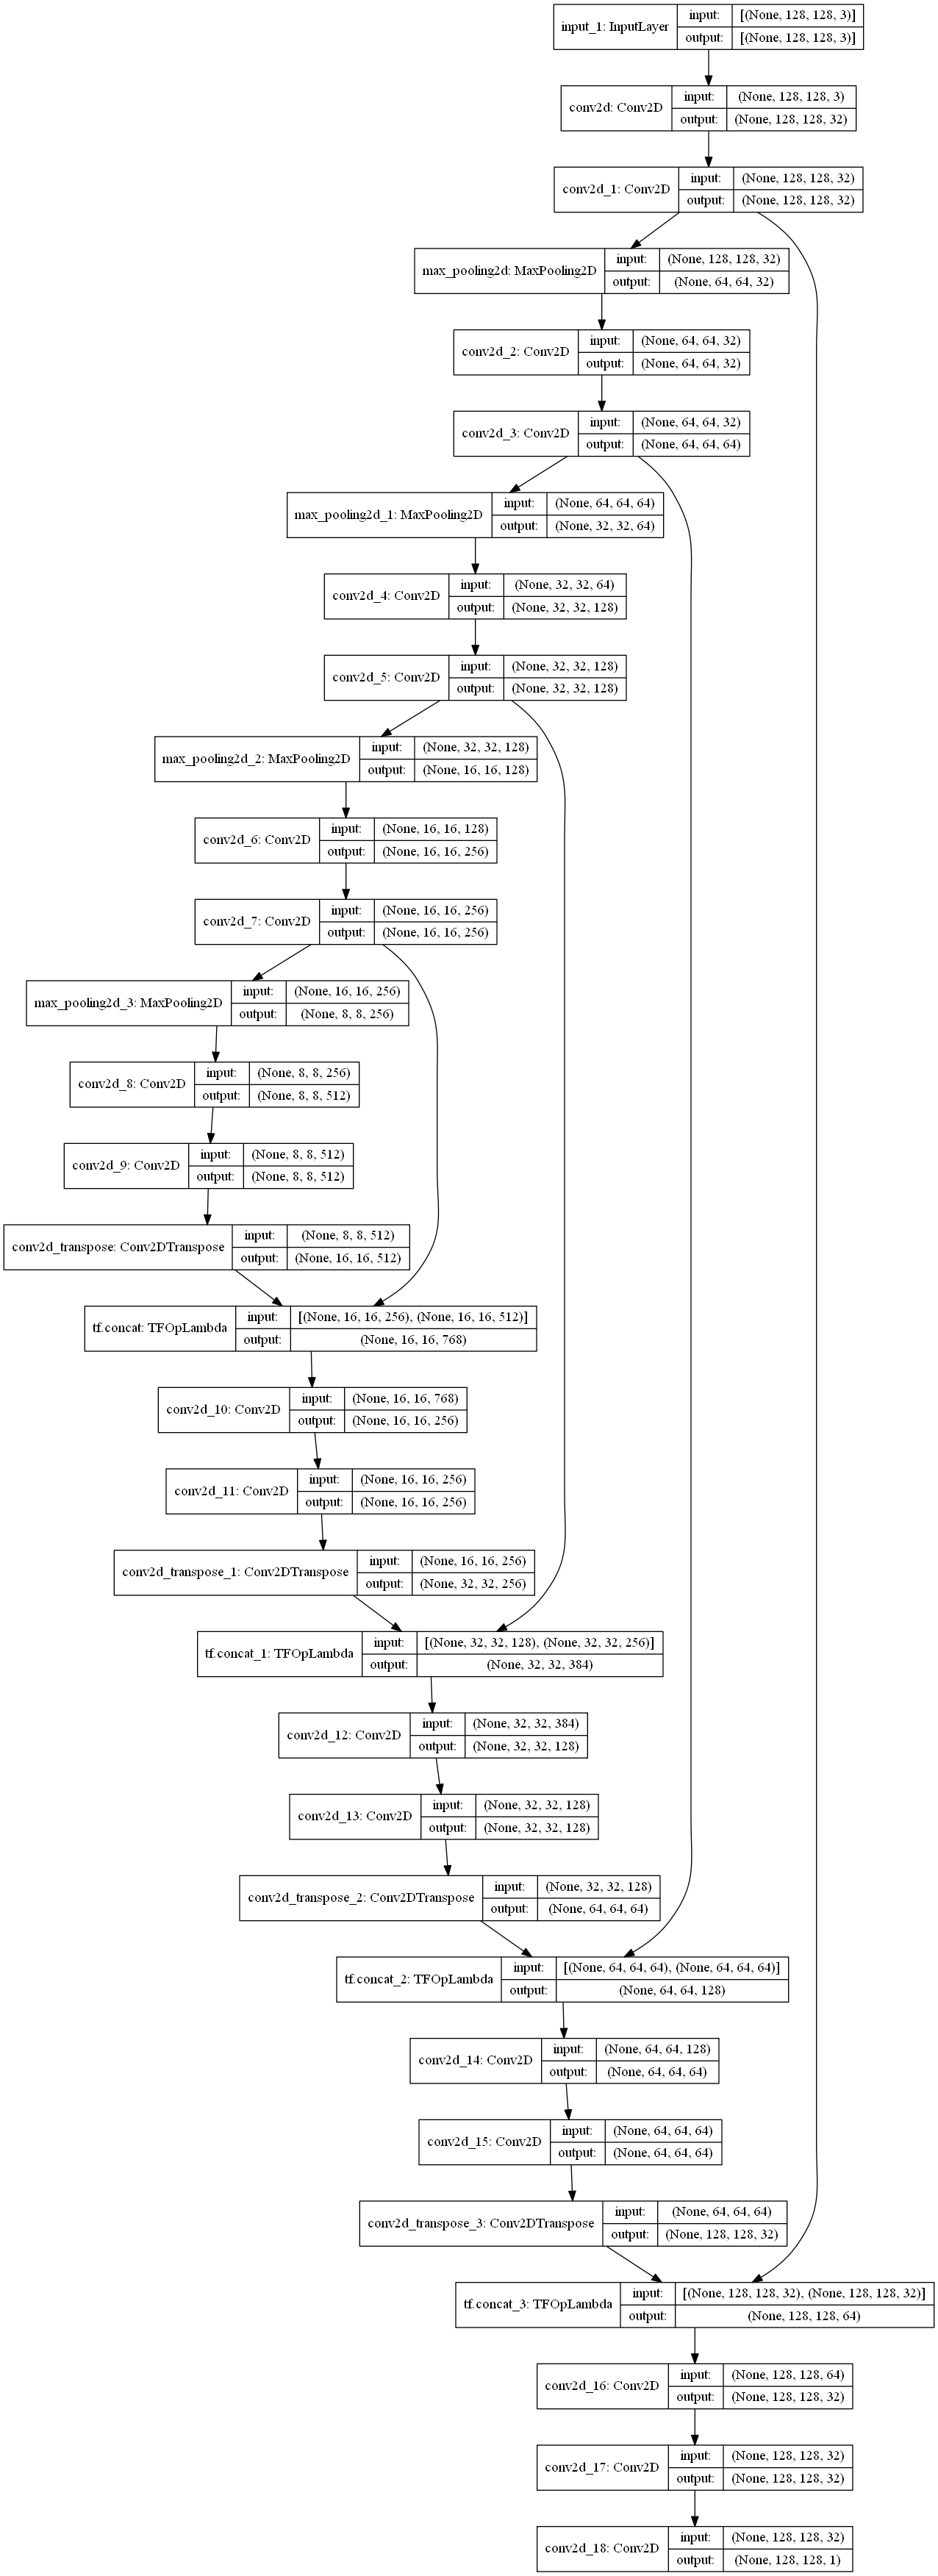

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
NUM_EPOCHS = 35
BATCH_SIZE = 35

In [13]:
val_ds = COCO_dataset_val.train_dataset(epochs=4,inp_size=128, batch_size=BATCH_SIZE)

Epoch 1/35
307/307 [==============================] - 278s 857ms/step - loss: 0.5228
Epoch 2/35
307/307 [==============================] - 247s 805ms/step - loss: 0.4697
Epoch 3/35
307/307 [==============================] - 228s 744ms/step - loss: 0.4601
Epoch 4/35
307/307 [==============================] - 226s 737ms/step - loss: 0.4535
Epoch 5/35
307/307 [==============================] - 232s 756ms/step - loss: 0.4329
Epoch 6/35
307/307 [==============================] - 235s 765ms/step - loss: 0.4158
Epoch 7/35
307/307 [==============================] - 242s 787ms/step - loss: 0.4065
Epoch 8/35
307/307 [==============================] - 252s 819ms/step - loss: 0.3921
Epoch 9/35
307/307 [==============================] - 266s 865ms/step - loss: 0.3814
Epoch 10/35
307/307 [==============================] - 289s 942ms/step - loss: 0.3791
Epoch 11/35
307/307 [==============================] - 300s 977ms/step - loss: 0.3726
Epoch 12/35
307/307 [==============================] - 304s 991

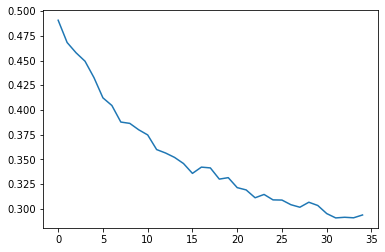

In [14]:
%%time

loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)
hist = model.fit(val_ds, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)
plt.plot(hist.history['loss'])

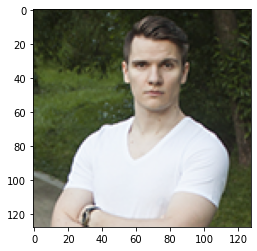

In [15]:
img = imageio.imread('me_128.png')
img = img.astype(np.float32) / 255.
_=plt.imshow(img)

In [16]:
train_x = np.stack((img, img[:,::-1,:]))

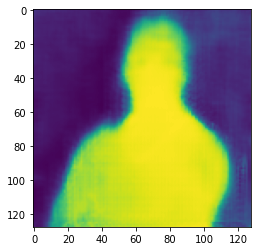

In [17]:
out = model.predict(img[None, ...])[0, ...]
_=plt.imshow(out[...,0])

__Выводы:__
1. Случайный кроп позволяет эффективнее обучать нейросеть.
2. Из-за большого объема датасета пришлось разворачивать нейросеть на локальной машине.
3. Для того, чтобы обучить нейросеть за приемлемое время использовать валидационную выборку.
4. Для того чтобы хватало памяти на GPU пришлось изменить размер картинки с 256 до 128 пикселов по линейным размерам.
5. Где-то на 40 эпохе GPU зависало и перегружалось, пришлось ограничить количество эпох 35. При размере входной картинки 100 пикселов или уменьшении батча можно было бы обучить нейросетку на 100 эпохах, чтобы увеличило точность и края распознанного сегмента были бы более четкие.
6. При увеличении батча, скорость обучения возрастает.
7. При увеличении количества эпох обучения точность семантической сегментации увеличивается и края распознанного сегмента становятся более четкими.